In [1]:
import pandas as pd
import numpy as np
import os 

import sklearn
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

# Data Preprocessing
Imported the SAheart.txt file into a pandas dataframe, removed unused columns, and replaced the values in the column 'famhist' into 1s and 0s.

In [2]:
# importing SAheart.txt into df
filename = os.path.join(os.getcwd(),"SAheart.txt")
df = pd.read_csv(filename, delimiter = ",", index_col=0)
df.reset_index(drop=True, inplace=True)

# Columns not used in the textbook's analysis
df.drop(columns=['adiposity','typea'],inplace=True)

# Edited the famhist column(Present=1, Absent=0)
df['famhist'].replace('Present', 1, inplace=True)
df['famhist'].replace('Absent', 0, inplace=True)
df

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
0,160,12.00,5.73,1,25.30,97.20,52,1
1,144,0.01,4.41,0,28.87,2.06,63,1
2,118,0.08,3.48,1,29.14,3.81,46,0
3,170,7.50,6.41,1,31.99,24.26,58,1
4,134,13.60,3.50,1,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,0,28.45,0.00,58,0
458,182,4.20,4.41,0,28.61,18.72,52,1
459,108,3.00,1.59,0,20.09,26.64,55,0
460,118,5.40,11.61,0,27.35,23.97,40,0


Replicate the analysis of the South African heart disease dataset from the Elements of Statistical Learning textbook and plot figure 4.12

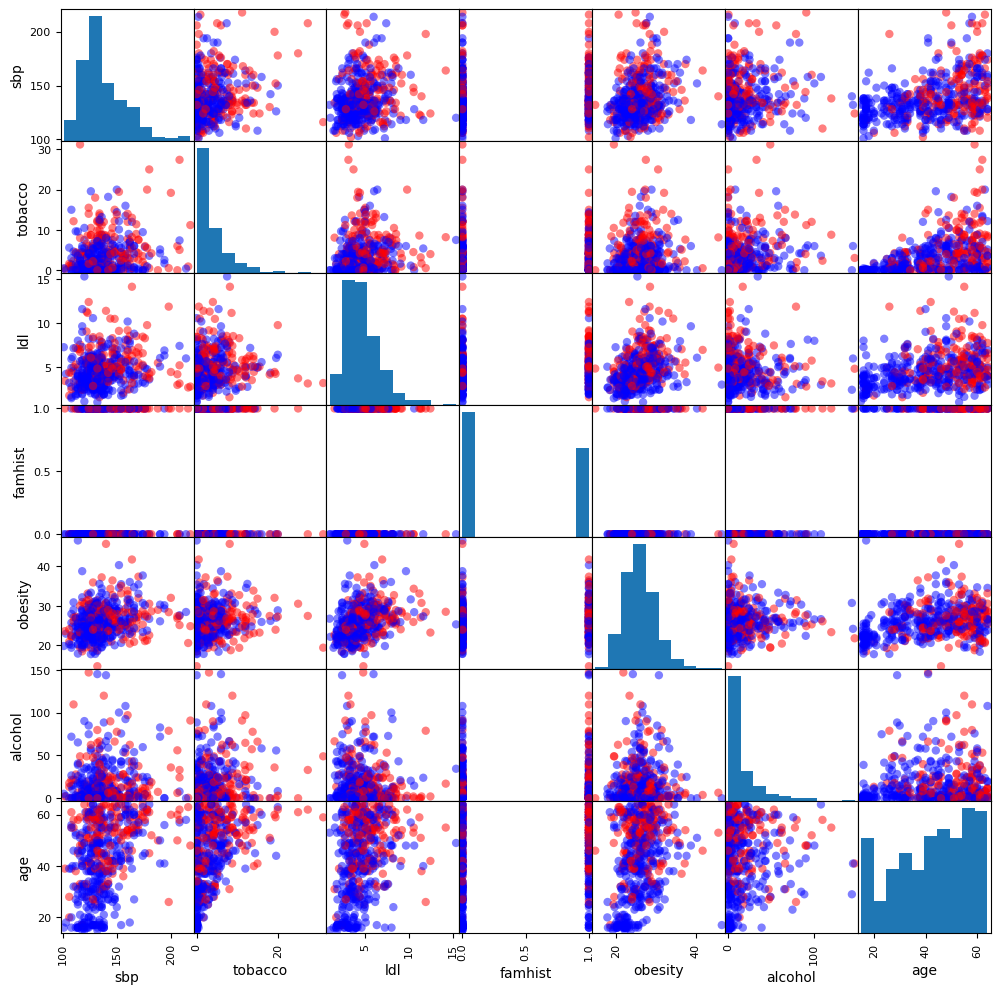

In [3]:
# Creating Labels and Features
y = df['chd']
X = df.drop(columns='chd',inplace=False)

# Figure 4.12
# to get different colors for 'Present' and 'Absent'
ycol = df['chd'].copy()
ycol.loc[ycol==1] = 'red'
ycol.loc[ycol==0] = 'blue'
pd.plotting.scatter_matrix(X, marker = 'O', figsize = (12,12), color = ycol)
plt.show()

In [4]:
# a function to split the dataset into train, val, and test
def train_val_test_split(X,y,seed):
    X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size =0.2, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5, random_state=seed)
    X_train_std = (X_train-X_train.mean())/(X_train.std())
    X_val_std = (X_val-X_train.mean())/(X_train.std())
    X_test_std = (X_test-X_train.mean())/(X_train.std())
    y_train_std = (y_train-y_train.mean())/(y_train.std())
    y_val_std = (y_val-y_train.mean())/(y_train.std())
    y_test_std = (y_test-y_train.mean())/(y_train.std())

    return X_train, X_val, X_test, X_train_std, X_val_std, X_test_std, y_train, y_val, y_test, y_train_std, y_val_std, y_test_std

# split the prostate data
X_train, X_val, X_test, X_train_std, X_val_std, X_test_std, y_train, y_val, y_test, y_train_std, y_val_std, y_test_std = train_val_test_split(X,y,723)

In [5]:
# Inserting a column of ones to get the intercept
X_train_std.insert(0,"Intercept",np.ones((len(X_train_std),1)),allow_duplicates=False)
X_val_std.insert(0,"Intercept",np.ones((len(X_val_std),1)),allow_duplicates=False)
X_test_std.insert(0,"Intercept",np.ones((len(X_test_std),1)),allow_duplicates=False)

# Logistic Regression with Stochastic Gradient Descent, without the L2 Regularization Penalty

In [6]:
def sigmoid(X_train_std, theta_list):
    z = np.dot(X_train_std, np.transpose(theta_list))
    h = 1/(1+np.exp(-z))
    return h

# SGD0 is for no-L2-Regularization-Penalty

def SGD0(X_train_std, y_train_std, alpha):

    #initializing an array for storing thetas
    num_features = len(X_train_std.columns)
    thetas = np.ones(num_features)
  
    #initializing an array to store log likelihood values
    loglikelihood = []
    temp = 0
    for i in range(len(X_train_std)):
        h = sigmoid(X_train_std.iloc[i],thetas)
        diff = y_train_std.iloc[i] - h
        thetas = thetas + alpha * diff * X_train_std.iloc[i]
        temp = temp + np.log(h)*(y_train_std.iloc[i]) + (1-y_train_std.iloc[i])*(np.log(1-h))
        loglikelihood.append(temp)
    return thetas, loglikelihood

# Logistic Regression with Stochastic Gradient Descent, with the L2 Regularization Penalty

In [7]:
# SGD2 is for SGD with L2 Regularization Penalty

def SGD2(X_train_std, y_train_std, alpha, lmda):

    #initializing an array for storing thetas
    num_features = len(X_train_std.columns)
    thetas = np.ones(num_features)
  
    #initializing an array to store log likelihood values
    loglikelihood = []
    temp = 0
    for i in range(len(X_train_std)):
        h = sigmoid(X_train_std.iloc[i],thetas)
        diff = y_train_std.iloc[i] - h
        thetas = thetas + alpha * diff * X_train_std.iloc[i]-2*lmda*thetas
        temp = temp + np.log(h)*(y_train_std.iloc[i]) + (1-y_train_std.iloc[i])*(np.log(1-h))
        loglikelihood.append(temp)
    return thetas, loglikelihood

# Stepwise

In [8]:
# A function to calculate the percent correct

def percentcorr(thetas, X_test_std):
    count = 0   # a count var to store # of correct predictions
  
    for i in range(len(X_test_std)):
        h = sigmoid(X_test_std.iloc[i], thetas)
        prediction = 0
        if h > 0.5:
            prediction = 1
        if prediction == y_test.iloc[i]:
            count = count + 1
  
    percent_correct = (count/len(X_test_std)) * 100
  
    return percent_correct

In [9]:
features = ['Intercept','sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
basis = 0
selected_features = []

for i in range(len(features)):
    temp_features = selected_features.copy()
    temp_features.append(features[i])
    
    thetasstep, loglikestep = SGD0(X_train_std[temp_features], y_train_std, 0.01)
    perc = percentcorr(thetasstep, X_test_std[temp_features])
    
    if perc>basis:
        basis = perc
        selected_features.append(features[i])

print("Most important features = ", selected_features[1:len(selected_features)])

Most important features =  ['tobacco', 'obesity']


Here, I have found the most important features using forward stepwise, by cross-validating the train dataset against the test dataset using the a function that I created (percentcorr) that calculates the percentage of correct predictions.

# Stretch Goal 1
Implement the L1 penalty as well, and produce a Lasso plot like figure 4.13. Include your results in the % correct table. Use the validation dataset to select the optimal lambda and determine the most important features. Do those features agree with the stepwise feature selection?

In [10]:
# SGD1 is for SGD with L1 Regularization Penalty

def SGD1(X_train_std, y_train_std, alpha, lmda):

    #initializing an array for storing thetas
    num_features = len(X_train_std.columns)
    thetas = np.ones(num_features)
  
    #initializing an array to store log likelihood values
    loglikelihood = []
    temp = 0
    for i in range(len(X_train_std)):
        h = sigmoid(X_train_std.iloc[i],thetas)
        diff = y_train_std.iloc[i] - h
        thetas = thetas + alpha * diff * X_train_std.iloc[i] - lmda*alpha*np.sign(thetas)
        temp = temp + np.log(h)*(y_train_std.iloc[i]) + (1-y_train_std.iloc[i])*(np.log(1-h))
        loglikelihood.append(temp)
    return thetas, loglikelihood

In [15]:
# Sweeping through the lambda
lmda = np.linspace(0,2,100)
basis = 0
best_lmda = 0
thetalist_l1 = []

for i in range(len(lmda)):
    thetal1, loglikel1 = SGD1(X_train_std, y_train_std, 0.01, lmda[i])
    thetalist_l1.append(thetal1)
    percl1 = percentcorr(thetal1, X_test_std)
    if percl1 > basis:
        basis = percl1
        best_lmda_index = i
        best_lmda = lmda[i]
best_lmda

0.2828282828282829

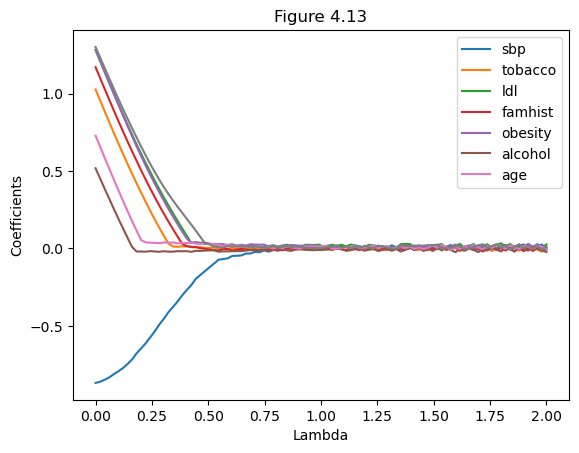

In [16]:
plt.figure()
plt.plot(lmda, thetalist_l1)
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Figure 4.13")
plt.legend(X_train.columns)
plt.show()

# Results

In [17]:
thetas0, loglike0 = SGD0(X_train_std, y_train_std, 0.1)
thetas2, loglike2 = SGD2(X_train_std, y_train_std, 0.1, 0.001)
theta_step, loglike_step = SGD0(X_train_std[selected_features], y_train_std, 0.01)
thetas1, loglike1 = SGD1(X_train_std, y_train_std, 0.1, best_lmda)

perc0 = percentcorr(thetas0, X_test_std)
perc2 = percentcorr(thetas2, X_test_std)
perc_step = percentcorr(theta_step, X_test_std[selected_features])
perc1 = percentcorr(thetas1, X_test_std)

In [18]:
df_results = pd.DataFrame()
df_results["No Regularization"] = thetas0
df_results["L1 Regularization"] = thetas1
df_results["L2 Regularization"] = thetas2
df_results["Stepwise"] = theta_step
df_results.loc["Percent Correct", "No Regularization"] = perc0
df_results.loc["Percent Correct", "L2 Regularization"] = perc2
df_results.loc["Percent Correct", "Stepwise"] = perc_step
df_results.loc["Percent Correct", "L1 Regularization"] = perc1

df_results

,No Regularization,L1 Regularization,L2 Regularization,Stepwise
Intercept,-10.015272,-1.528450,-7.107803,-0.810665
sbp,2.587822,0.151869,1.816034,NaN
tobacco,3.967579,0.384951,2.943322,1.367393
ldl,3.713716,0.163107,2.625217,NaN
famhist,4.132605,0.442107,2.801045,NaN
obesity,-0.619734,-0.223443,-0.478125,0.620205
alcohol,0.077265,0.392612,-0.054068,NaN
age,6.368649,0.706846,4.772548,NaN
Percent Correct,80.851064,68.085106,80.851064,78.723404
